# Ensemble Voting
### Imports

In [1]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

### Paths

In [2]:
DATA_DIR = "../data/splits"
MODEL_DIR = "../models"
ENSEMBLE_DIR = "../models/ensemble"

os.makedirs(ENSEMBLE_DIR, exist_ok=True)

TEST_PATH = f"{DATA_DIR}/test.csv"

DT_MODEL_PATH  = f"{MODEL_DIR}/decision_tree/model.joblib"
XGB_MODEL_PATH = f"{MODEL_DIR}/xgboost/model.joblib"
SVM_MODEL_PATH = f"{MODEL_DIR}/svm/model.joblib"

TARGET_COL = "target"

### Loading Test Data

In [3]:
test_df = pd.read_csv(TEST_PATH)

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

print("Test shape:", X_test.shape)
print("Target distribution:")
print(y_test.value_counts())

Test shape: (664, 36)
Target distribution:
target
Graduate    331
Dropout     214
Enrolled    119
Name: count, dtype: int64


### Loading Trained Models

In [4]:
dt_model  = joblib.load(DT_MODEL_PATH)
xgb_model = joblib.load(XGB_MODEL_PATH)
svm_model = joblib.load(SVM_MODEL_PATH)

print("Models loaded successfully")

Models loaded successfully


### Define Class Order

In [5]:
CLASS_ORDER = sorted(y_test.unique().tolist())
print("Class order:", CLASS_ORDER)

Class order: ['Dropout', 'Enrolled', 'Graduate']


## Aligned Probabilities
### Decision Tree

In [6]:
dt_proba = dt_model.predict_proba(X_test)
dt_classes = dt_model.classes_

dt_proba_aligned = np.zeros((X_test.shape[0], len(CLASS_ORDER)))

for i, cls in enumerate(CLASS_ORDER):
    dt_proba_aligned[:, i] = dt_proba[:, list(dt_classes).index(cls)]

### XGBoost

In [7]:
xgb_classes = sorted(y_test.unique().tolist())
xgb_label_to_id = {c: i for i, c in enumerate(xgb_classes)}

xgb_proba_raw = xgb_model.predict_proba(X_test)

xgb_proba_aligned = np.zeros((X_test.shape[0], len(CLASS_ORDER)))
for i, cls in enumerate(CLASS_ORDER):
    xgb_proba_aligned[:, i] = xgb_proba_raw[:, xgb_label_to_id[cls]]

### Support Vector Machine

In [8]:
svm_proba = svm_model.predict_proba(X_test)
svm_classes = svm_model.classes_

svm_proba_aligned = np.zeros((X_test.shape[0], len(CLASS_ORDER)))

for i, cls in enumerate(CLASS_ORDER):
    svm_proba_aligned[:, i] = svm_proba[:, list(svm_classes).index(cls)]

## Voting Ensemble

In [9]:
ensemble_proba = (
    dt_proba_aligned +
    xgb_proba_aligned +
    svm_proba_aligned
) / 3.0

ensemble_pred_idx = np.argmax(ensemble_proba, axis=1)
ensemble_preds = [CLASS_ORDER[i] for i in ensemble_pred_idx]

### Evaluate Ensemble Performance

In [10]:
ensemble_acc = accuracy_score(y_test, ensemble_preds)
cm = confusion_matrix(y_test, ensemble_preds)

print("Ensemble Test Accuracy:", round(ensemble_acc, 4))
print("\nClassification Report (Ensemble):")
print(classification_report(y_test, ensemble_preds))

Ensemble Test Accuracy: 0.7846

Classification Report (Ensemble):
              precision    recall  f1-score   support

     Dropout       0.86      0.74      0.80       214
    Enrolled       0.55      0.51      0.53       119
    Graduate       0.82      0.91      0.86       331

    accuracy                           0.78       664
   macro avg       0.74      0.72      0.73       664
weighted avg       0.78      0.78      0.78       664



### Saving Metrics

In [11]:
metrics = {
    "model": "Soft Voting Ensemble",
    "base_models": ["Decision Tree", "XGBoost", "SVM"],
    "accuracy": float(ensemble_acc),
    "confusion_matrix": cm.tolist(),
    "classification_report": classification_report(
        y_test, ensemble_preds, output_dict=True
    )
}

metrics_path = f"{ENSEMBLE_DIR}/metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved:", metrics_path)

Saved: ../models/ensemble/metrics.json


### Saving Confusion Matrix

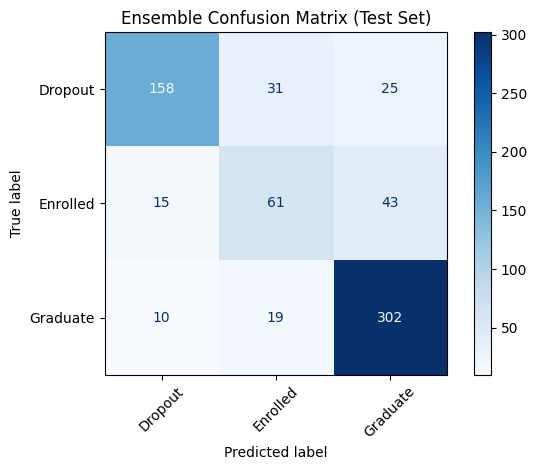

Saved: ../models/ensemble/confusion_matrix.png


In [12]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=CLASS_ORDER
)

disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ensemble Confusion Matrix (Test Set)")
plt.tight_layout()

cm_path = f"{ENSEMBLE_DIR}/confusion_matrix.png"
plt.savefig(cm_path)
plt.show()

print("Saved:", cm_path)